**importing Libraries**

In [1]:
!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
import joblib
# Apply nest_asyncio so uvicorn can run inside notebook
from pydantic import BaseModel


from threading import Thread
import requests

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

# **Reading Data**

In [3]:
data=pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 




* SeniorCitizen : age 65 or older
*  tenure : Number of months the customer has stayed with the company







In [5]:
data.iloc[0]

,0
customerID,7590-VHVEG
gender,Female
SeniorCitizen,0
Partner,Yes
Dependents,No
tenure,1
PhoneService,No
MultipleLines,No phone service
InternetService,DSL
OnlineSecurity,No


# **EDA**

## Customer Churn Distribution

<ipython-input-6-b88bbdf8d85a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Churn', palette='Set2')


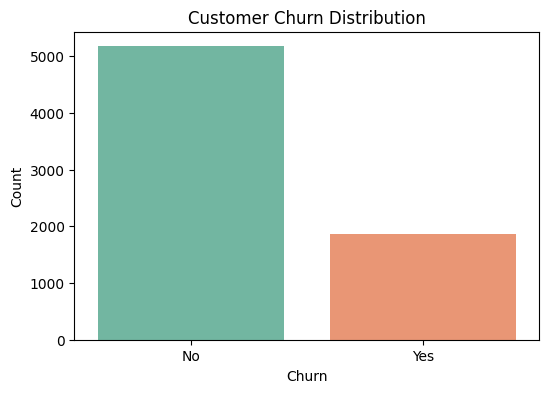

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='Churn', palette='Set2')
plt.title('Customer Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


## **Customer Churn Distribution (Percentage)**

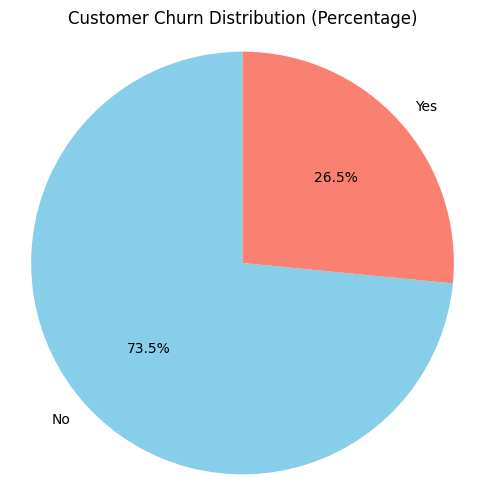

In [7]:
churn_percent = data['Churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(6,6))
plt.pie(churn_percent, labels=churn_percent.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
plt.title('Customer Churn Distribution (Percentage)')
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.show()


### **Customer Gender percent  Distribution (Percentage)**

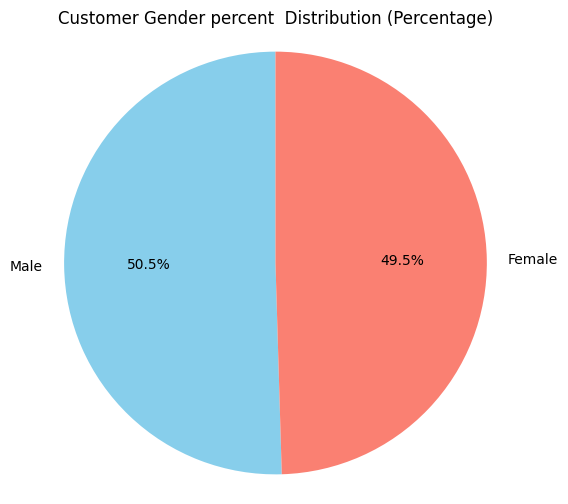

In [8]:
gender_percent = data['gender'].value_counts(normalize=True) * 100

plt.figure(figsize=(6,6))
plt.pie(gender_percent, labels=gender_percent.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
plt.title('Customer Gender percent  Distribution (Percentage)')
plt.axis('equal')  # Equal aspect ratio makes the pie chart circular
plt.show()


## **Churn Percentage of Male and Female Customers**

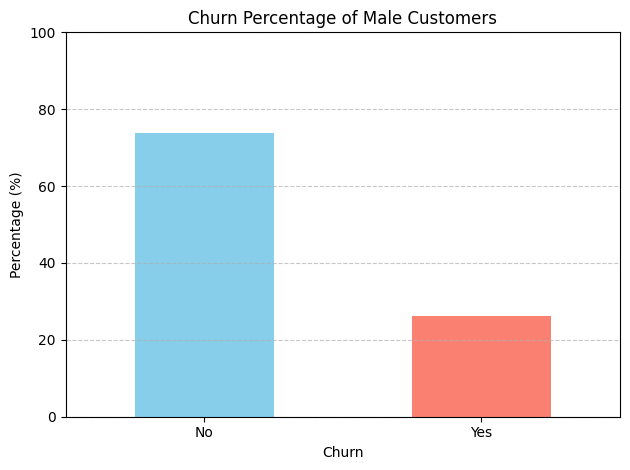

In [9]:
male_churn_counts = data[data['gender'] == 'Male']['Churn'].value_counts(normalize=True) * 100

# Plotting
male_churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Churn Percentage of Male Customers')
plt.xlabel('Churn')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## **Tenure vs. Churn**

<ipython-input-10-eaa4abb4890a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Churn', y='tenure', palette='Set2')


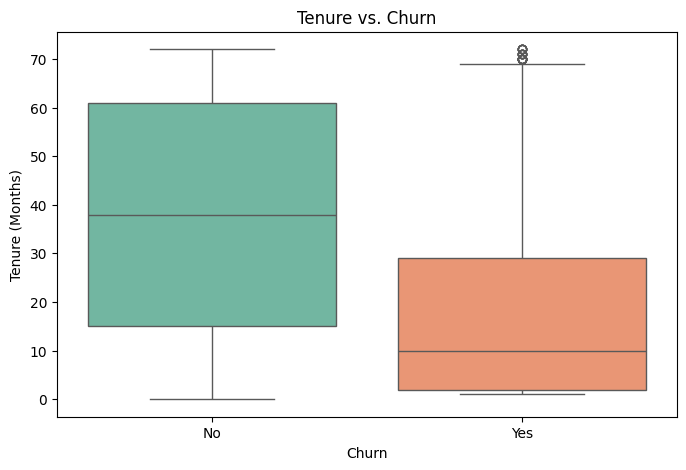

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='Churn', y='tenure', palette='Set2')
plt.title('Tenure vs. Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (Months)')
plt.show()


## Customers who churned ("Yes"):

Tend to have low tenure (many stayed less than 10 months).

Median tenure is around 10 months.

A few stayed longer (outliers up to ~70 months), but these are rare.

## Customers who stayed ("No"):

Have a much higher median tenure (~38 months).

Wider distribution with many staying longer than 50 months.

**Preprocessing**

In [11]:
data.drop('customerID', axis=1, inplace=True)

In [12]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [13]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')


## **Distribution of Numeric coulmns**

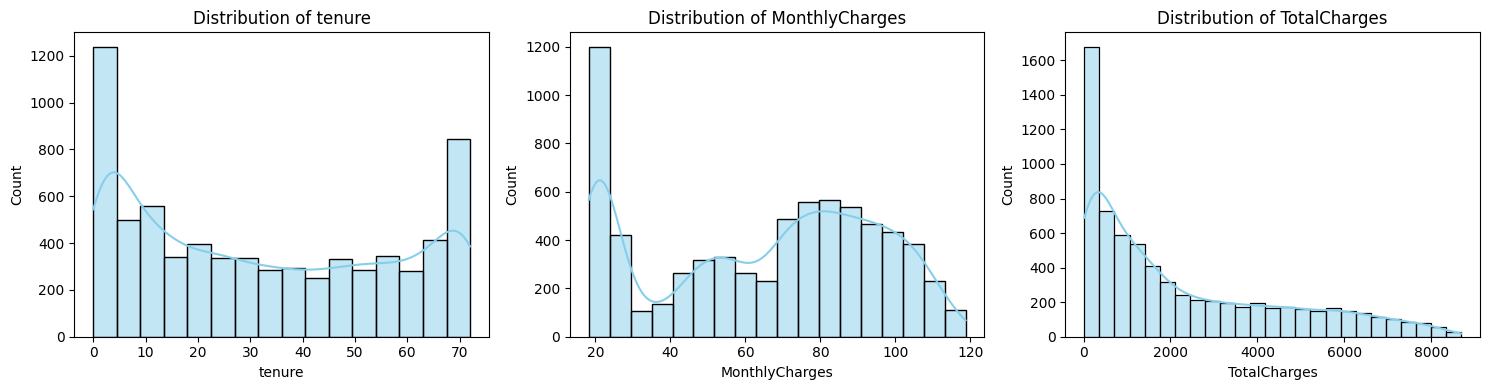

In [14]:
plt.figure(figsize=(15, 4))

for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


# Distribution of Numerical columns
### **Tenure The distribution is bimodal (two peaks)**:

A large number of customers left very early (tenure = 0–10 months).

Another spike at around 70 months → long-term loyal customers.

Customers either leave early or stay for a long time.

Highly right-skewed, so scaling is needed .

### **MonthlyCharges This distribution is multi-modal (several peaks)**.

The first peak is near 20– 30, and another large cluster is between 70– 90.

Customers tend to fall into two or more pricing tiers.

feature isn’t strongly skewed, but still not normal.

### **TotalCharges Strong right-skewed distribution.**

Many customers have very low total charges (i.e., short tenure).

Few customers have high total charges — likely long-term loyal ones.

 A direct product of MonthlyCharges × tenure (approximately).

### **Check for null values**

In [15]:
data.isnull().sum()


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [16]:
data[['TotalCharges', 'Churn','MonthlyCharges','tenure']][data['TotalCharges'].isnull()]


,TotalCharges,Churn,MonthlyCharges,tenure
488,NaN,No,52.55,0
753,NaN,No,20.25,0
936,NaN,No,80.85,0
1082,NaN,No,25.75,0
1340,NaN,No,56.05,0
3331,NaN,No,19.85,0
3826,NaN,No,25.35,0
4380,NaN,No,20.00,0
5218,NaN,No,19.70,0
6670,NaN,No,73.35,0


In [17]:
# Fix TotalCharges where tenure is 0
mask = (data['TotalCharges'].isnull()) & (data['tenure'] == 0)

data.loc[mask, 'TotalCharges'] = data.loc[mask, 'MonthlyCharges']
data.loc[mask, 'tenure'] = 1



In [18]:
print(data[["TotalCharges","Churn","MonthlyCharges","tenure"]].loc[mask])


      TotalCharges Churn  MonthlyCharges  tenure
488          52.55    No           52.55       1
753          20.25    No           20.25       1
936          80.85    No           80.85       1
1082         25.75    No           25.75       1
1340         56.05    No           56.05       1
3331         19.85    No           19.85       1
3826         25.35    No           25.35       1
4380         20.00    No           20.00       1
5218         19.70    No           19.70       1
6670         73.35    No           73.35       1
6754         61.90    No           61.90       1


**tenure as 0 is misleading, since there was a charge → means at least one billing cycle or a partial month.**

## **Checking for duplicated values**

In [19]:
duplicate_count = data.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)



Number of duplicate rows: 22


In [20]:
data = data.drop_duplicates(keep='first')


In [21]:
duplicate_count = data.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)



Number of duplicate rows: 0


**Encode and scale Categorical and Numerical features**

In [22]:
data['Churn'] = data['Churn'].map({'No': 0, 'Yes': 1})

<ipython-input-22-d5e3f896984f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Churn'] = data['Churn'].map({'No': 0, 'Yes': 1})


In [23]:
X_full = data.drop('Churn', axis=1)
y = data['Churn']

# Preprocessing
robust_scaled_cols_all = ['tenure', 'TotalCharges']
minmax_scaled_cols = ['MonthlyCharges']
categorical_cols = [
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod', 'gender', 'Partner', 'Dependents',
    'PhoneService', 'PaperlessBilling'
]


# **Heat map**

## **check for correlation between features**

In [24]:
preprocessor_all = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), robust_scaled_cols_all),
        ('minmax', MinMaxScaler(), minmax_scaled_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Transform all features
X_transformed = preprocessor_all.fit_transform(X_full)

# Feature names
ohe = preprocessor_all.named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)
all_features = robust_scaled_cols_all + minmax_scaled_cols + list(encoded_cat_cols)


X_encoded_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed,
                            columns=all_features)
X_encoded_df['Churn'] = y.values




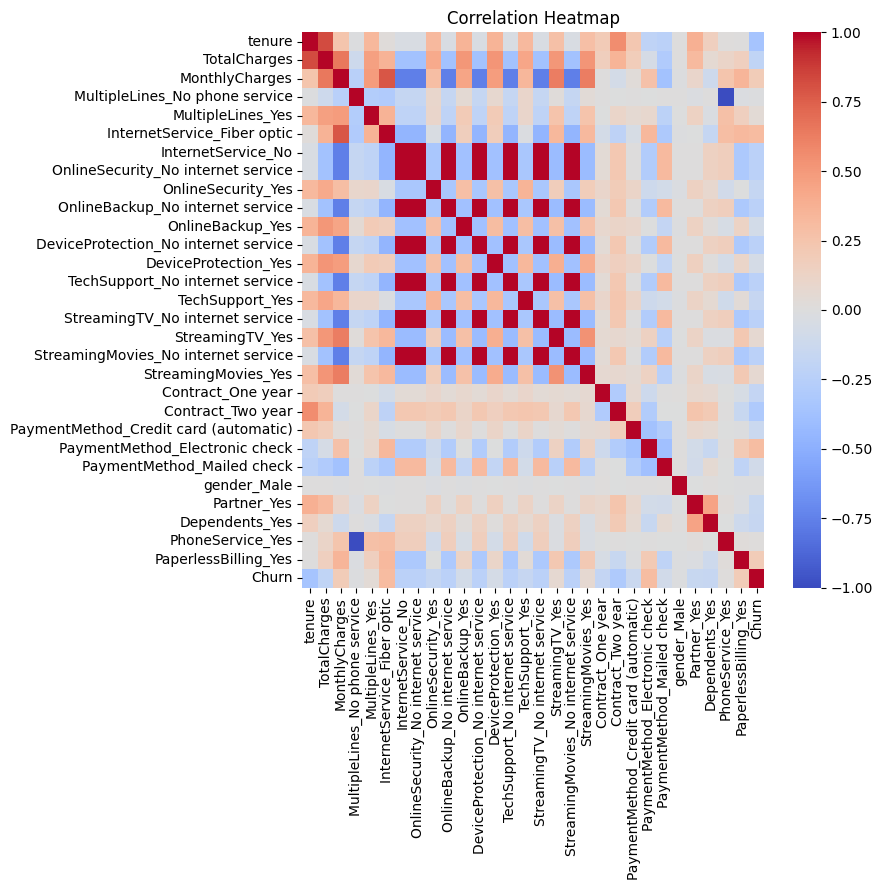

In [25]:
plt.figure(figsize=(9,9))
sns.heatmap(X_encoded_df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


### 🔍 Heatmap Interpretation: Correlation with Churn

| Feature                       | Correlation | Insight                                      | Action               |
|------------------------------|-------------|----------------------------------------------|----------------------|
| `tenure`                     | Negative    | Long-tenure customers are less likely to churn | ✅ Keep              |
| `Contract_Two year`          | Strong Negative | Long contracts reduce churn                  | ✅ Keep              |
| `InternetService_Fiber optic`| Positive     | Fiber users tend to churn more               | ✅ Keep              |
| `TechSupport_Yes`            | Negative     | Support helps retain customers               | ✅ Keep              |
| `OnlineSecurity_Yes`         | Negative     | Same — secure users churn less               | ✅ Keep              |
| `MonthlyCharges`             | Weak Positive | Higher charges slightly increase churn risk | ✅ Keep              |
| `PaperlessBilling_Yes`       | Weak Positive | Might slightly contribute to churn          | ✅ Keep              |
| `gender_Male`                | Near Zero    | No real effect on churn                      | ❌ Drop              |
| `PhoneService_Yes`           | Near Zero    | No meaningful impact                         | ❌ Drop              |
| `TotalCharges`               | Redundant (Derived from tenure × monthly) | Covered by other features | ❌ Drop for LR only |


:::### 💡 Feature Selection Decision: Handling `TotalCharges`

Based on the correlation heatmap, `TotalCharges` is moderately correlated with `Churn`, but it is also highly related to other features like `MonthlyCharges` and `tenure` since:

> TotalCharges ≈ MonthlyCharges × tenure

In **Logistic Regression**, which is a linear model, including highly correlated features can cause multicollinearity, making the model unstable or less interpretable.  
➡️ So, we decided to **remove `TotalCharges` for Logistic Regression** to improve generalization and avoid redundant information.

In contrast, **tree-based models like XGBoost and LightGBM are not sensitive to multicollinearity**. They can handle redundant features well and may even benefit from them.  
➡️ Therefore, I chose to **keep `TotalCharges` for tree-based models** to give them more flexibility in learning non-linear interactions.


In [26]:
features_to_drop_for_all = ['gender', 'PhoneService']
features_to_drop_for_lr = features_to_drop_for_all + ['TotalCharges']

# Logistic version
X_lr = data.drop(columns=features_to_drop_for_lr + ['Churn'])
y_lr = data['Churn']

# Tree version
X_tree = data.drop(columns=features_to_drop_for_all + ['Churn'])
y_tree = data['Churn']


## **Create preprocessor pipline for numerical**

In [27]:

updated_categorical_cols = [col for col in categorical_cols if col not in ['gender', 'PhoneService']]



# Preprocessors
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), ['tenure']),
        ('minmax', MinMaxScaler(), ['MonthlyCharges']),
        ('cat', OneHotEncoder(drop='first'),updated_categorical_cols)
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), ['tenure', 'TotalCharges']),
        ('minmax', MinMaxScaler(), ['MonthlyCharges']),
        ('cat', OneHotEncoder(drop='first'),updated_categorical_cols)
    ]
)


## **Modeling and Evaluation**

## **Spliting data for training and Testing**

In [28]:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y, test_size=0.2, random_state=42)
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y, test_size=0.2, random_state=42)


**first handel imbalanced data with class_weight=balanced**

## **1-Logistic Model**


In [29]:
# Logistic Regression
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])
pipe_lr.fit(X_lr_train, y_lr_train)
y_lr_pred = pipe_lr.predict(X_lr_test)


In [30]:
print(classification_report(y_lr_pred,y_lr_test))



              precision    recall  f1-score   support

           0       0.72      0.92      0.81       823
           1       0.81      0.49      0.61       582

    accuracy                           0.74      1405
   macro avg       0.77      0.71      0.71      1405
weighted avg       0.76      0.74      0.73      1405



## **Tuning logistic regression**

In [31]:
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}


In [32]:
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid_lr.fit(X_lr_train, y_lr_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('robust',
                                                                         RobustScaler(),
                                                                         ['tenure']),
                                                                        ('minmax',
                                                                         MinMaxScaler(),
                                                                         ['MonthlyCharges']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaymentMethod',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PaperlessBilling'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear']},
             scoring='f1', verbose=1)

In [33]:
best_log_model = grid_lr.best_estimator_

y_lrtuned_pred = best_log_model.predict(X_lr_test)

print("Best Parameters:", grid_lr.best_params_)
print(confusion_matrix(y_lr_test,y_lrtuned_pred))
print(classification_report(y_lr_test,y_lrtuned_pred))


Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
[[748 305]
 [ 70 282]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1053
           1       0.48      0.80      0.60       352

    accuracy                           0.73      1405
   macro avg       0.70      0.76      0.70      1405
weighted avg       0.81      0.73      0.75      1405



## **2-XGBoost model**

**scale_pos_weight = (neg / pos) to compensate for minority class**

In [34]:

neg = sum(y_tree_train == 0)
pos = sum(y_tree_train == 1)
scale_pos_weight = neg / pos
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")



Calculated scale_pos_weight: 2.73


In [35]:
# XGBOOST (Base)
pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', XGBClassifier(scale_pos_weight=scale_pos_weight,
                                 use_label_encoder=False,
                                 eval_metric='logloss',
                                 random_state=42))
])
pipe_xgb.fit(X_tree_train, y_tree_train)
y_xgb_pred = pipe_xgb.predict(X_tree_test)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:02:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [36]:
print("\nXGBoost (Base)")
print(confusion_matrix(y_tree_test, y_xgb_pred))
print(classification_report(y_tree_test, y_xgb_pred))


XGBoost (Base)
[[813 240]
 [123 229]]
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1053
           1       0.49      0.65      0.56       352

    accuracy                           0.74      1405
   macro avg       0.68      0.71      0.69      1405
weighted avg       0.77      0.74      0.75      1405



**TUNED XGBOOST**

In [37]:

param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [5, 7],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_xgb.fit(X_tree_train, y_tree_train)

best_xgb = grid_xgb.best_estimator_
y_xgb_tuned_pred = best_xgb.predict(X_tree_test)

print("\nXGBoost (Tuned)")
print("Best Params:", grid_xgb.best_params_)
print(confusion_matrix(y_tree_test, y_xgb_tuned_pred))
print(classification_report(y_tree_test, y_xgb_tuned_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:03:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost (Tuned)
Best Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
[[775 278]
 [ 77 275]]
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1053
           1       0.50      0.78      0.61       352

    accuracy                           0.75      1405
   macro avg       0.70      0.76      0.71      1405
weighted avg       0.81      0.75      0.76      1405



# 3-**LightGBM**

In [38]:

pipe_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', LGBMClassifier(class_weight='balanced', random_state=42))
])
pipe_lgbm.fit(X_tree_train, y_tree_train)
y_lgbm_pred = pipe_lgbm.predict(X_tree_test)

print("\nLightGBM (Base)")
print(confusion_matrix(y_tree_test, y_lgbm_pred))
print(classification_report(y_tree_test, y_lgbm_pred))

[LightGBM] [Info] Number of positive: 1505, number of negative: 4111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 5616, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LightGBM (Base)
[[787 266]
 [ 96 256]]
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1053
           1       0.49      0.73      0.59       352

    accuracy                           0.74      1405
   macro avg       0.69      0.74      0.70      1405
weighted avg       0.79      0.74      0.76      1405



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**TUNED LIGHTGBM**

In [39]:

param_grid_lgbm = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [5, 7]
}

grid_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_lgbm.fit(X_tree_train, y_tree_train)

best_lgbm = grid_lgbm.best_estimator_
y_lgbm_tuned_pred = best_lgbm.predict(X_tree_test)

print("\nLightGBM (Tuned)")
print("Best Params:", grid_lgbm.best_params_)
print(confusion_matrix(y_tree_test, y_lgbm_tuned_pred))
print(classification_report(y_tree_test, y_lgbm_tuned_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1505, number of negative: 4111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 5616, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LightGBM (Tuned)
Best Params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}
[[766 287]
 [ 75 277]]
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1053
           1       0.49      0.79      0.60       352

    accuracy                           0.74      1405
   macro avg       0.70      0.76      0.71      1405
weighted avg       0.81

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#4-**STACKING CLASSIFIER**

In [40]:

stack_model = StackingClassifier(
    estimators=[
        ('lgbm', best_lgbm.named_steps['classifier']),
        ('xgb', best_xgb.named_steps['classifier'])
    ],
    final_estimator=LGBMClassifier(class_weight='balanced', random_state=42)
)

pipe_stack = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', stack_model)
])
pipe_stack.fit(X_tree_train, y_tree_train)
y_stack_pred = pipe_stack.predict(X_tree_test)

print("\nStacking Classifier")
print(confusion_matrix(y_tree_test, y_stack_pred))
print(classification_report(y_tree_test, y_stack_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1505, number of negative: 4111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 5616, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:03:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1204, number of negative: 3288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 4492, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1204, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 4493, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1204, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 4493, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1204, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 4493, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1204, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 4493, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:03:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1505, number of negative: 4111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5616, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Stacking Classifier
[[762 291]
 [ 80 272]]
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1053
           1       0.48      0.77      0.59       352

    accuracy                           0.74      1405
   macro avg       0.69      0.75      0.70      1405
weighted avg       0.80      0.74      0.75      1405



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**try oversampling method**

In [41]:
!pip install -U imbalanced-learn


In [42]:
X_lr_train_enc = preprocessor_lr.fit_transform(X_lr_train)
X_lr_test_enc = preprocessor_lr.transform(X_lr_test)

X_tree_train_enc = preprocessor_tree.fit_transform(X_tree_train)
X_tree_test_enc = preprocessor_tree.transform(X_tree_test)

# 🔹 Step 2: Apply SMOTE
sm = SMOTE(random_state=42)
X_lr_res, y_lr_res = sm.fit_resample(X_lr_train_enc, y_lr_train)
X_tree_res, y_tree_res = sm.fit_resample(X_tree_train_enc, y_tree_train)

In [43]:
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_lr_res, y_lr_res)
y_lr_pred_smote = lr_smote.predict(X_lr_test_enc)

print("Logistic Regression (SMOTE)")
print(confusion_matrix(y_lr_test, y_lr_pred_smote))
print(classification_report(y_lr_test, y_lr_pred_smote))

Logistic Regression (SMOTE)
[[779 274]
 [ 74 278]]
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1053
           1       0.50      0.79      0.62       352

    accuracy                           0.75      1405
   macro avg       0.71      0.76      0.72      1405
weighted avg       0.81      0.75      0.77      1405



In [44]:
lgbm_smote = LGBMClassifier(random_state=42)
lgbm_smote.fit(X_tree_res, y_tree_res)
y_lgbm_pred_smote = lgbm_smote.predict(X_tree_test_enc)

print("LightGBM (SMOTE)")
print(confusion_matrix(y_tree_test, y_lgbm_pred_smote))
print(classification_report(y_tree_test, y_lgbm_pred_smote))


[LightGBM] [Info] Number of positive: 4111, number of negative: 4111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 8222, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM (SMOTE)
[[873 180]
 [125 227]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1053
           1       0.56      0.64      0.60       352

    accuracy                           0.78      1405
   macro avg       0.72      0.74      0.72      1405
weighted avg       0.80      0.78      0.79      1405



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [45]:
xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_smote.fit(X_tree_res, y_tree_res)
y_xgb_pred_smote = xgb_smote.predict(X_tree_test_enc)

print("XGBoost (SMOTE)")
print(confusion_matrix(y_tree_test, y_xgb_pred_smote))
print(classification_report(y_tree_test, y_xgb_pred_smote))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:03:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (SMOTE)
[[864 189]
 [135 217]]
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1053
           1       0.53      0.62      0.57       352

    accuracy                           0.77      1405
   macro avg       0.70      0.72      0.71      1405
weighted avg       0.78      0.77      0.77      1405



In [46]:
stack_smote = StackingClassifier(
    estimators=[
        ('lgbm', lgbm_smote),
        ('xgb', xgb_smote)
    ],
    final_estimator=LGBMClassifier(random_state=42)
)
stack_smote.fit(X_tree_res, y_tree_res)
y_stack_pred_smote = stack_smote.predict(X_tree_test_enc)

print("Stacking Classifier (SMOTE)")
print(confusion_matrix(y_tree_test, y_stack_pred_smote))
print(classification_report(y_tree_test, y_stack_pred_smote))


[LightGBM] [Info] Number of positive: 4111, number of negative: 4111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 8222, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:03:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3288, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 6577, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499924 -> initscore=-0.000304
[LightGBM] [Info] Start training from score -0.000304


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3289, number of negative: 3288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 6577, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500076 -> initscore=0.000304
[LightGBM] [Info] Start training from score 0.000304


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3289, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1356
[LightGBM] [Info] Number of data points in the train set: 6578, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3289, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1354
[LightGBM] [Info] Number of data points in the train set: 6578, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3289, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 6578, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:03:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:03:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:03:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:04:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not

[LightGBM] [Info] Number of positive: 4111, number of negative: 4111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 8222, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Stacking Classifier (SMOTE)
[[877 176]
 [136 216]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1053
           1       0.55      0.61      0.58       352

    accuracy                           0.78      1405
   macro avg       0.71      0.72      0.71      1405
weighted avg       0.79      0.78      0.78      1405



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## **Conclusion**

**Our business goal is to catch churned customers**
so our top priority :

✅ High Recall for Class 1 (Churn)
To reduce false negatives — we don’t want to miss customers who are about to leave.

✅ But also aim for:
Acceptable Precision — so you're not wasting effort/resources on customers who weren’t really at risk



##  Model Comparison: Focus on Churn Class (1) – Precision vs Recall

Since our objective is to catch as many churned customers as possible, **Recall for Class 1 (Churn)** is our top priority. However, we also want **Precision** to remain acceptable to avoid too many false alarms.

| Model                          | Precision (Churn) | Recall (Churn) | F1-score | Comment                                     |
|-------------------------------|-------------------|----------------|----------|---------------------------------------------|
| Logistic Regression (Base)    | 0.81              | 0.49           | 0.61     | High precision but low recall               |
| Logistic Regression (Tuned)   | 0.48              | 0.80           | 0.60     | High recall, decent tradeoff                |
| **Logistic Regression (SMOTE)**| **0.50**          | **0.79**       | 0.62     | Strong balance using SMOTE                  |
| XGBoost (Base)                | 0.49              | 0.65           | 0.56     | Low recall compared to others               |
| XGBoost (Tuned)               | 0.50              | 0.78           | 0.61     | High recall, improved over base             |
| **XGBoost (SMOTE)**           | 0.53              | 0.62           | 0.57     | Best precision with decent recall           |
| LightGBM (Base)               | 0.49              | 0.73           | 0.59     | Good recall                                 |
| LightGBM (Tuned)              | 0.49              | 0.79           | 0.60     | Best recall overall                         |
| Stacking Classifier (Base)    | 0.48              | 0.77           | 0.59     | High recall, low precision                  |
| **Stacking Classifier (SMOTE)**| 0.55              | 0.61           | 0.58     | Best balance between precision & recall     |

---



**Candidate Models Summary (for Churn Class):**

| Model                       | Recall | Precision | F1-score | Notes                                          |
| --------------------------- | ------ | --------- | -------- | ---------------------------------------------- |
| Logistic Regression (SMOTE) | 0.79   | 0.50      | 0.62     | High recall, interpretable, simple to deploy ✅ |
| LightGBM (Tuned)            | 0.79   | 0.49      | 0.60     | Highest recall but slightly lower precision    |
| XGBoost (SMOTE)             | 0.62   | 0.53      | 0.57     | Balanced, more conservative                    |
| Stacking (SMOTE)            | 0.61   | 0.55      | 0.58     | Balanced but slightly lower recall             |



Logistic Regression with SMOTE is the best model to deploy in our case:


1.   It gives very high recall (0.79)
2.   Is easy to explain to stakeholders
3. Fast to serve in APIs
4. Lightweight for cloud or edge deployment
5. Precision is reasonable (0.50) .






**SAVE Logistic Regression with SMOTE**

In [47]:
# Save the fitted model
joblib.dump(lr_smote, 'logistic_smote_model.pkl')

#  save the preprocessor
joblib.dump(preprocessor_lr, 'preprocessor_lr.pkl')

['preprocessor_lr.pkl']